### Feature Engineering 
Author: Anne Tumlin

Date: 04/05/25

Now that we have our baseline results, our goal is to perform feature engineering and hyperparameter tuning to improve our existing results. First, I will investigate feature engineering by checking various correlations. 

First, load in the dataset (via parquet file) for evaluation. 

In [2]:
import os
import subprocess
import time
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, input_file_name, expr, sum as spark_sum, avg, count

spark = SparkSession.builder \
    .appName("app_name") \
    .getOrCreate()

In [4]:
start_time = time.time()

df = spark.read.parquet("gs://ds5460-tumlinam-fp-bucket/processed_data/agg_df.parquet")

end_time = time.time()
print(f"Reading took {end_time - start_time:.2f} seconds")

Reading took 0.48 seconds


In [6]:
df.show(5) # verify loaded data

+--------------------+--------------+------------------+------+------------------+-----------------+------------------+---------+------------------+--------------------+--------------------+------------------+----------+----------+--------------------+-------------------+-----------------+------------------+------------------+
|            filename|num_generators|          total_pg|avg_vg|  avg_cost_squared|  avg_cost_linear|   avg_cost_offset|num_loads|          total_pd|           br_r_mean|           br_x_mean|        rate_a_sum|rate_b_min|rate_c_max|     trans_br_r_mean|    trans_br_x_mean| trans_rate_a_sum|          tap_mean|        total_cost|
+--------------------+--------------+------------------+------+------------------+-----------------+------------------+---------+------------------+--------------------+--------------------+------------------+----------+----------+--------------------+-------------------+-----------------+------------------+------------------+
|gs://ds5460-

Our `total_cost` depends on multiple system-wide parameters (generation, loads, rates, cost curves). So, to enhance our features we will refine them to create the new features for our model to utilize. 

In [7]:
from pyspark.sql.functions import col

df = df.withColumn("cost_per_gen", col("total_cost") / col("num_generators"))
df = df.withColumn("cost_per_mw", col("total_cost") / col("total_pg"))
df = df.withColumn("generation_margin", col("total_pg") - col("total_pd"))
df = df.withColumn("load_to_gen_ratio", col("total_pd") / col("total_pg"))
df = df.withColumn("trans_to_br_ratio_r", col("trans_br_r_mean") / col("br_r_mean"))
df = df.withColumn("trans_to_br_ratio_x", col("trans_br_x_mean") / col("br_x_mean"))
df = df.withColumn("trans_rate_ratio", col("trans_rate_a_sum") / col("rate_a_sum"))
df = df.withColumn("load_per_generator", col("num_loads") / col("num_generators"))
df = df.withColumn("pd_per_load", col("total_pd") / col("num_loads"))

In [8]:
df.show(5) # verify new features

+--------------------+--------------+------------------+------+------------------+-----------------+------------------+---------+------------------+--------------------+--------------------+------------------+----------+----------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+
|            filename|num_generators|          total_pg|avg_vg|  avg_cost_squared|  avg_cost_linear|   avg_cost_offset|num_loads|          total_pd|           br_r_mean|           br_x_mean|        rate_a_sum|rate_b_min|rate_c_max|     trans_br_r_mean|    trans_br_x_mean| trans_rate_a_sum|          tap_mean|        total_cost|      cost_per_gen|       cost_per_mw|  generation_margin| load_to_gen_ratio|trans_to_br_ratio_r|trans_to_br_ratio_x|  trans_rate_ratio|load_per_generator|       pd_per_

In [ ]:
from pyspark.sql.functions import corr

feature_cols = [c for c in df.columns if c not in ['filename', 'total_cost']]

start_time = time.time()
correlations = []
for col_name in feature_cols:
    corr_value = df.select(corr(col_name, "total_cost").alias("corr")).collect()[0]["corr"]
    if corr_value is None:
        correlations.append((col_name, None))
    else:
        correlations.append((col_name, corr_value))

sorted_correlations = sorted(correlations, key=lambda x: abs(x[1]) if x[1] is not None else 0, reverse=True)

for feature, value in sorted_correlations:
    if value is not None:
        print(f"{feature:25} -> {value:.4f}")
    else:
        print(f"{feature:25} -> None (possibly constant)")
end_time = time.time() 
print(f"Correlation evaluation took {end_time - start_time:.2f} seconds")

cost_per_mw               -> 1.0000
cost_per_gen              -> 1.0000
total_pd                  -> 0.9990
pd_per_load               -> 0.9990
generation_margin         -> -0.9990
load_to_gen_ratio         -> 0.9990
trans_br_r_mean           -> -0.0125
num_generators            -> None (possibly constant)
total_pg                  -> None (possibly constant)
avg_vg                    -> None (possibly constant)
avg_cost_squared          -> None (possibly constant)
avg_cost_linear           -> None (possibly constant)
avg_cost_offset           -> None (possibly constant)
num_loads                 -> None (possibly constant)
br_r_mean                 -> None (possibly constant)
br_x_mean                 -> None (possibly constant)
rate_a_sum                -> None (possibly constant)
rate_b_min                -> None (possibly constant)
rate_c_max                -> None (possibly constant)
trans_br_x_mean           -> None (possibly constant)
trans_rate_a_sum          -> None (possibly 

A lot of our values are returning None which implies that our features are constant (since we already checked for Null values). Therefore, let's investigate further and potentially prune the features that provide no usefullness for modeling. 

In [ ]:
from pyspark.sql.functions import countDistinct
# How many unique values are there per column?
for col_name in feature_cols:
    unique_vals = df.select(countDistinct(col_name)).collect()[0][0]
    print(f"{col_name:25} | Unique values: {unique_vals}")

num_generators            | Unique values: 1
total_pg                  | Unique values: 1
avg_vg                    | Unique values: 1
avg_cost_squared          | Unique values: 1
avg_cost_linear           | Unique values: 1
avg_cost_offset           | Unique values: 1
num_loads                 | Unique values: 1
total_pd                  | Unique values: 15000
br_r_mean                 | Unique values: 1
br_x_mean                 | Unique values: 1
rate_a_sum                | Unique values: 1
trans_br_x_mean           | Unique values: 1
trans_rate_a_sum          | Unique values: 1
tap_mean                  | Unique values: 1
cost_per_gen              | Unique values: 15000
cost_per_mw               | Unique values: 15000
generation_margin         | Unique values: 15000
load_to_gen_ratio         | Unique values: 15000
trans_to_br_ratio_r       | Unique values: 1
trans_to_br_ratio_x       | Unique values: 1
trans_rate_ratio          | Unique values: 1
load_per_generator        | Unique 

In [ ]:
from pyspark.sql.functions import col, isnan, when, count
# Just to verify that there are no null values...
for col_name in feature_cols:
    nulls = df.select(count(when(col(col_name).isNull() | isnan(col(col_name)), col_name))).collect()[0][0]
    print(f"{col_name:25} | Null/NaN count: {nulls}")

num_generators            | Null/NaN count: 0
total_pg                  | Null/NaN count: 0
avg_vg                    | Null/NaN count: 0
avg_cost_squared          | Null/NaN count: 0
avg_cost_linear           | Null/NaN count: 0
avg_cost_offset           | Null/NaN count: 0
num_loads                 | Null/NaN count: 0
total_pd                  | Null/NaN count: 0
br_r_mean                 | Null/NaN count: 0
br_x_mean                 | Null/NaN count: 0
rate_a_sum                | Null/NaN count: 0
rate_b_min                | Null/NaN count: 0
rate_c_max                | Null/NaN count: 0
trans_br_r_mean           | Null/NaN count: 0
trans_br_x_mean           | Null/NaN count: 0
trans_rate_a_sum          | Null/NaN count: 0
tap_mean                  | Null/NaN count: 0
cost_per_gen              | Null/NaN count: 0
cost_per_mw               | Null/NaN count: 0
generation_margin         | Null/NaN count: 0
trans_rate_ratio          | Null/NaN count: 0
load_per_generator        | Null/N

From the analysis above, we can see that a decent amount of our features columns are constant. However, none of our columns have Null/NaN values. Therefore, we will prune the columns which contain constants.  

In [18]:
constant_cols = []

for col_name in feature_cols:
    unique_vals = df.select(countDistinct(col_name)).collect()[0][0]
    if unique_vals <= 1:
        constant_cols.append(col_name)

print("Dropping constant columns:", constant_cols)

# Drop them from the dataframe
df_cleaned = df.drop(*constant_cols)

Dropping constant columns: ['num_generators', 'total_pg', 'avg_vg', 'avg_cost_squared', 'avg_cost_linear', 'avg_cost_offset', 'num_loads', 'br_r_mean', 'br_x_mean', 'rate_a_sum', 'rate_b_min', 'rate_c_max', 'trans_br_r_mean', 'trans_br_x_mean', 'trans_rate_a_sum', 'tap_mean', 'trans_to_br_ratio_r', 'trans_to_br_ratio_x', 'trans_rate_ratio', 'load_per_generator']


In [19]:
df_cleaned.show(5)

+--------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|            filename|          total_pd|        total_cost|      cost_per_gen|       cost_per_mw|  generation_margin| load_to_gen_ratio|       pd_per_load|
+--------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|gs://ds5460-tumli...|178.07434280491296| 457017.6915453811|2672.6180792127548| 2964.789502387657|-23.925897804912978| 1.155213358168569|0.6337165224374126|
|gs://ds5460-tumli...|177.75404115936618|454991.87287162687| 2660.771186383783| 2951.647503623062|  -23.6055961593662|1.1531354802791958|0.6325766589301287|
|gs://ds5460-tumli...|176.44749746510547|448851.02127889916|2624.8597735608137| 2911.810244202588| -22.29905246510549|1.1446596004591905|0.6279270372423682|
|gs://ds5460-tumli...|179.48218836865323|463761.2446537249

Now that we have shrunk our feature space to non-constant features, let's analyze the data and provide some normalizations. 

In [20]:
df_cleaned.select(
    "total_pd", "total_cost", "cost_per_gen", "cost_per_mw",
    "generation_margin", "load_to_gen_ratio", "pd_per_load"
).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show(truncate=False)

+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+
|summary|total_pd          |total_cost        |cost_per_gen      |cost_per_mw       |generation_margin  |load_to_gen_ratio  |pd_per_load         |
+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+
|count  |15000             |15000             |15000             |15000             |15000              |15000              |15000               |
|mean   |177.71919542785122|455058.1915002695 |2661.159014621464 |2952.0777293619167|-23.57075042785142 |1.1529094271943596 |0.6324526527681542  |
|stddev |1.425026235409197 |6803.242668321199 |39.785044843983606|44.13435807491406 |1.425026235409197  |0.00924450606951759|0.005071267741669744|
|min    |172.39261507968072|431924.47773403546|2525.8741387955292|2802.003469668705 |-29.115787346540202|1.11835455154

In [22]:
%matplotlib inline

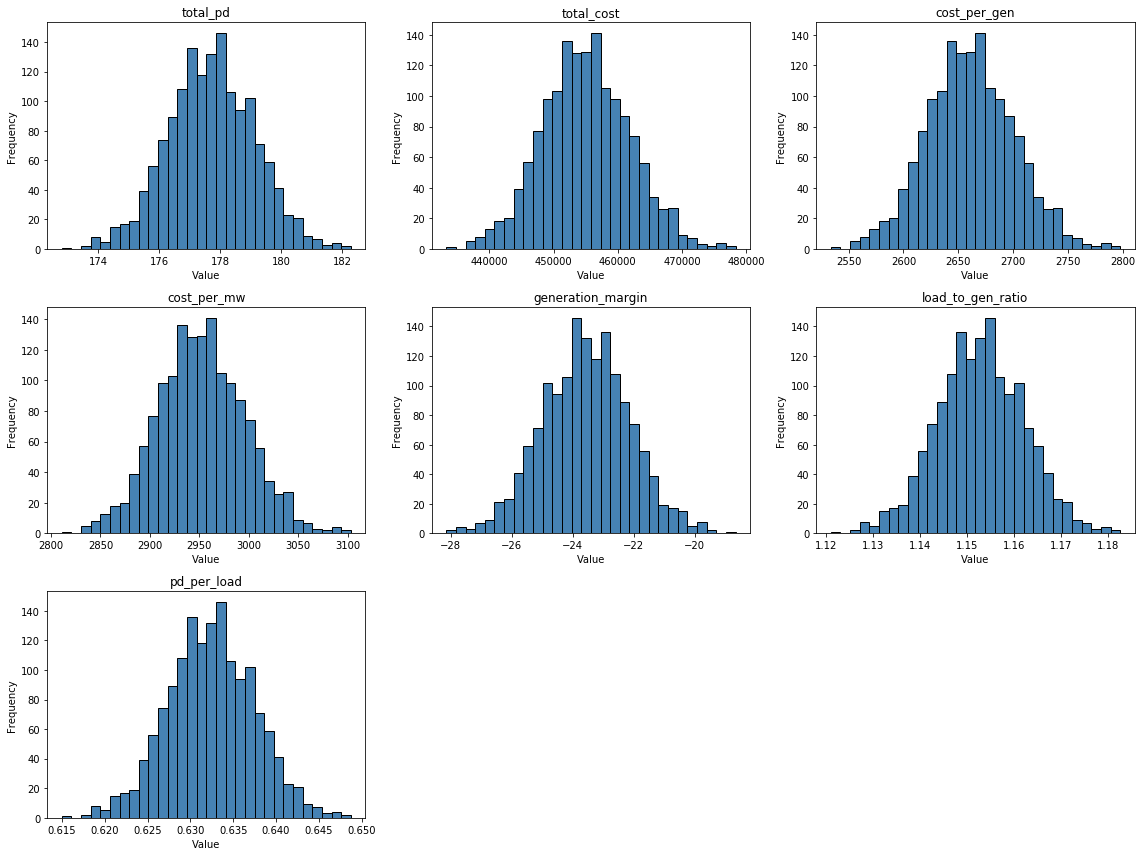

In [24]:
import matplotlib.pyplot as plt

features = [
    "total_pd", "total_cost", "cost_per_gen", "cost_per_mw",
    "generation_margin", "load_to_gen_ratio", "pd_per_load"
]

# Sample ~10% of data to speed things up
sample_df = df_cleaned.select(*features).sample(fraction=0.1, seed=42).dropna()
sample_pd = sample_df.toPandas()

# Plot
plt.figure(figsize=(16, 12))
for i, col_name in enumerate(features, 1):
    plt.subplot(3, 3, i)
    plt.hist(sample_pd[col_name], bins=30, color='steelblue', edgecolor='black')
    plt.title(col_name)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Based on the histograms above, we can see that our features are continuous, rought symmetric, not heavily skewed, and no extreme outliers. For Linear Regression models we will need to have normalization, but for tree-based models we will not need scaling. 